# Module 5 Project — ML Regressions

**Author**: deffip2@illinois.edu

### Objective: Implementing Machine Learning Regressions method to predict rain rate (mm/hr) from provided radar data

This notebook:
1) Radar parameters data in the csv format

2) Predict the rain rate from other radar parameter using several methods: \
a. Baseline with Z-R relationship \
b. Linear regression \
c. Polynomial regression (0 to 9 degree) \
d. Random forest regressor 

3) Evaluate the performance of each method using R^2 and RMSE

> **Data**: `homework/radar_parameters.csv` (in the repository).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

## 1. **Data Loading**

We use the radar parameter data in csv format:

1. Zh (dBZ): Radar reflectivity
2. Zdr (dB): Differential reflectivity
3. Ldr (dB): Linear depolarization ratio
4. Kdp (degree/km): Specific differential phase
5. Ah (dBz/km): Specific attenuation
6. Adr (dB/km): Differential attenuation
7. R (mm/hr): Rain rate

We set the data into 70% of training data and 30% of test data. The targeted variable to predict in this work is `Rain Rate`

In [2]:
data_path = "homework/radar_parameters.csv"

df = pd.read_csv(data_path)
print("Data shape:", df.shape)
df.head()

Data shape: (18969, 8)


,Unnamed: 0,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291


In [3]:
required_cols = ["Zh (dBZ)", "Zdr (dB)", "Ldr (dB)", "Kdp (deg km-1)", "Ah (dBZ/km)", "Adr (dB/km)", "R (mm/hr)"]

df = df.dropna(subset=required_cols).reset_index(drop=True)
print("After NA drop:", df.shape)

After NA drop: (18969, 8)


In [4]:
# X is the predictor and y is the predictan
X_cols = ["Zh (dBZ)", "Zdr (dB)", "Ldr (dB)", "Kdp (deg km-1)", "Ah (dBZ/km)", "Adr (dB/km)"]
y_col = "R (mm/hr)"

X = df[X_cols].copy()
y = df[y_col].astype(float).copy()

# 70/30 split (70% for training data and 30% for test data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((13278, 6), (5691, 6))

In [ ]:
# calculate rmse from mean squared error (sklearn)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 2. BASELINE WITH Z-R RELATIONSHIP

We predict the rain rate using `only Zh data` for Baseline

Given Zh is in dBZ and *dBZ = 10log10(Z)*, so *Z = 10^(dBZ/10)* \
Baseline predicts *R = (Z / 200)^(1/1.6)*

In [8]:
def baseline_ZR(zh_dbz: np.ndarray) -> np.ndarray:
    Z_lin = 10.0 ** (zh_dbz / 10.0)
    R_pred = (Z_lin / 200.0) ** (1.0 / 1.6)
    return R_pred

baseline_pred_train = baseline_ZR(X_train["Zh (dBZ)"].values)
baseline_pred_test  = baseline_ZR(X_test["Zh (dBZ)"].values)

## 3. LINEAR REGRESSION

In this linear regression method, we add a setting `StandardScaler` to put all features on the same scale so that the linear regression model treats them fairly and avoids bias toward variables with larger numeric ranges.

In [9]:
linreg = make_pipeline(StandardScaler(with_mean=True, with_std=True),
                       LinearRegression())
linreg.fit(X_train, y_train)

lin_pred_train = linreg.predict(X_train)
lin_pred_test  = linreg.predict(X_test)

#### **ANSWER FOR HW 5 number 2: The comparison between baseline and linreg**

Linear regression has better performance compare to the baseline that only use Zh for rain rate prediction. Baseline provides larger error. 

In [16]:
# The statistic calculation using sklearn metric and numpy square rooot for rmse
baseline_linreg_metrics = pd.DataFrame({
    "model": ["Baseline", "Linear"],
    "R2_train": [r2_score(y_train, baseline_pred_train),
                 r2_score(y_train, lin_pred_train)],
    "R2_test":  [r2_score(y_test, baseline_pred_test),
                 r2_score(y_test,  lin_pred_test)],
    "RMSE_train": [rmse(y_train, baseline_pred_train),
                   rmse(y_train, lin_pred_train)],
    "RMSE_test":  [rmse(y_test, baseline_pred_test),
                   rmse(y_test,  lin_pred_test)],
})

display(baseline_linreg_metrics)

,model,R2_train,R2_test,RMSE_train,RMSE_test
0,Baseline,0.285136,0.339928,7.174181,7.118734
1,Linear,0.987696,0.989631,0.941193,0.892211


## 4. POLYNOMIAL REGRESSION

In this work we will examine 0 to 9 degree with 7 folds. We standarize all parameters with `StandardScaler` similar like linear regression. \
We also select the best model that maximizes the R² score. 

In [11]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree),
        LinearRegression(**kwargs)
    )

poly_param_grid = {
    "polynomialfeatures__degree": list(range(0, 10))
}

grid_poly = GridSearchCV(
    PolynomialRegression(),
    param_grid=poly_param_grid,
    cv=7,
    scoring="r2",
    n_jobs=-1,
    refit=True
)

grid_poly.fit(X_train, y_train)


,estimator,Pipeline(step...egression())])
,param_grid,"{'polynomialfeatures__degree': [0, 1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,7
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [19]:
best_poly = grid_poly.best_estimator_
best_poly_degree = grid_poly.best_params_["polynomialfeatures__degree"]
best_poly_cvscore = grid_poly.best_score_

poly_pred_train= best_poly.predict(X_train)
poly_pred_test  = best_poly.predict(X_test)

poly_metrics = pd.DataFrame([{
    "model": f"The Best Polynomial Regression (degree={best_poly_degree})",
    "R2_train": r2_score(y_train, poly_pred_train),
    "RMSE_train": rmse(y_train, poly_pred_train),
    "R2_test": r2_score(y_test, poly_pred_test),
    "RMSE_test": rmse(y_test, poly_pred_test),
}])

display(poly_metrics)

,model,R2_train,RMSE_train,R2_test,RMSE_test
0,The Best Polynomial Regression (degree=3),0.999999,0.009311,0.999988,0.030814


## 5. RANDOM FOREST REGRESSOR

We first perform a grid search on the Random Forest model using 7-fold cross-validation.

The search tests different settings for the given hyperparameters.

We save the computation time by doing:
1. We set the fix number of trees at 200
2. Once we find the best hyperparameters, we update the model to use 1000 trees with the same best settings.

This way, we avoid wasting hours testing 1000 trees during the search.


In [ ]:
forest = RandomForestRegressor(random_state=RANDOM_STATE, max_samples=0.7)

param_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200],
}

grid_rf = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    scoring="r2",
    cv=7,
    n_jobs=4,
    refit=True,
)

grid_rf.fit(X_train, y_train)

/data/keeling/a/deffip2/miniconda3/envs/xarray-climate/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
112 fits failed out of a total of 224.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
112 fits failed with the following error:
Traceback (most recent call last):
  File "/data/keeling/a/deffip2/miniconda3/envs/xarray-climate/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data/keeling/a/deffip2/miniconda3/envs/xarray-climate/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **k

,estimator,RandomForestR...andom_state=1)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [10, 100], 'max_features': ['sqrt', 1.0], 'min_samples_leaf': [1, 4], ...}"
,scoring,'r2'
,n_jobs,4
,refit,True
,cv,7
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [22]:
best_params_rf = grid_rf.best_params_.copy()
best_params_rf["n_estimators"] = 1000 

best_rf = RandomForestRegressor(**best_params_rf, random_state=RANDOM_STATE)
best_rf.fit(X_train, y_train)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,100
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
rf_pred_train = best_rf.predict(X_train)
rf_pred_test  = best_rf.predict(X_test)

print(f"The best hyperparameter setting of RF:\n{best_params_rf}")

rf_metrics = pd.DataFrame({
    "model": ["Random Forest"],
    "R2_train": [r2_score(y_train, rf_pred_train)],
    "RMSE_train": [rmse(y_train, rf_pred_train)],
    "R2_test": [r2_score(y_test, rf_pred_test)],
    "RMSE_test": [rmse(y_test, rf_pred_test)],
})

rf_metrics

The best hyperparameter setting of RF:
{'bootstrap': True, 'max_depth': 100, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


,model,R2_train,RMSE_train,R2_test,RMSE_test
0,Random Forest,0.99747,0.4268,0.990037,0.87459


## 6. COMPARISON BETWEEN EACH METHODS

We recall all metrics calculation for each method to compare them

In [26]:
final_metrics = pd.concat(
    [
        baseline_linreg_metrics,
        poly_metrics,
        rf_metrics,
    ],
    ignore_index=True
)

,model,R2_train,R2_test,RMSE_train,RMSE_test
0,Baseline,0.285136,0.339928,7.174181,7.118734
1,Linear,0.987696,0.989631,0.941193,0.892211
2,The Best Polynomial Regression (degree=3),0.999999,0.999988,0.009311,0.030814
3,Random Forest,0.997470,0.990037,0.426800,0.874590


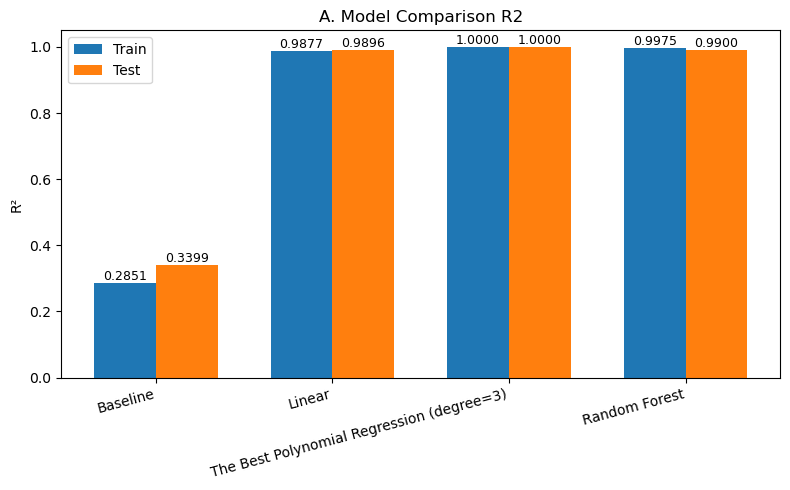

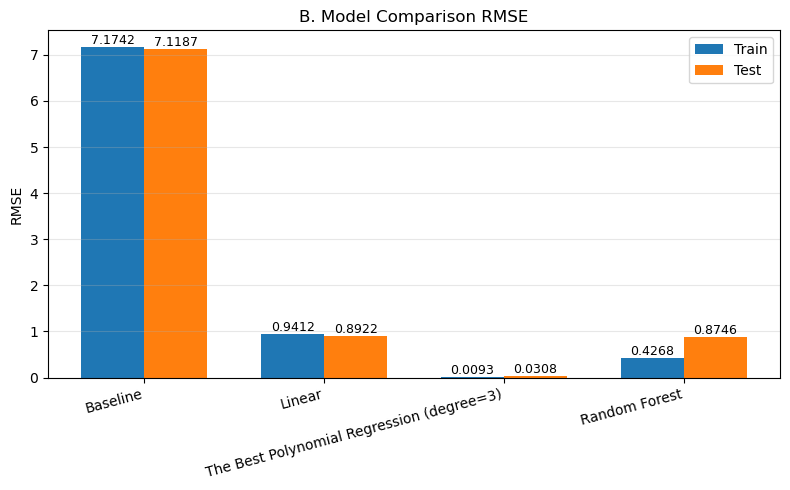

In [35]:
display(final_metrics)
# Visualize the R2
labels = final_metrics["model"].tolist()
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - w/2, final_metrics["R2_train"], width=w, label="Train")
ax.bar(x + w/2, final_metrics["R2_test"],  width=w, label="Test")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("R²")
ax.set_title("A. Model Comparison R2")
ax.legend()


# Annotate
for i, v in enumerate(final_metrics["R2_train"]):
    ax.text(i - w/2, v, f"{v:.4f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(final_metrics["R2_test"]):
    ax.text(i + w/2, v, f"{v:.4f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Visualize the RMSE
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - w/2, final_metrics["RMSE_train"], width=w, label="Train")
ax.bar(x + w/2, final_metrics["RMSE_test"],  width=w, label="Test")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("RMSE")
ax.set_title("B. Model Comparison RMSE")
ax.legend()
ax.grid(axis="y", alpha=0.3)
#anotate
for i, v in enumerate(final_metrics["RMSE_train"]):
    ax.text(i - w/2, v, f"{v:.4f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(final_metrics["RMSE_test"]):
    ax.text(i + w/2, v, f"{v:.4f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


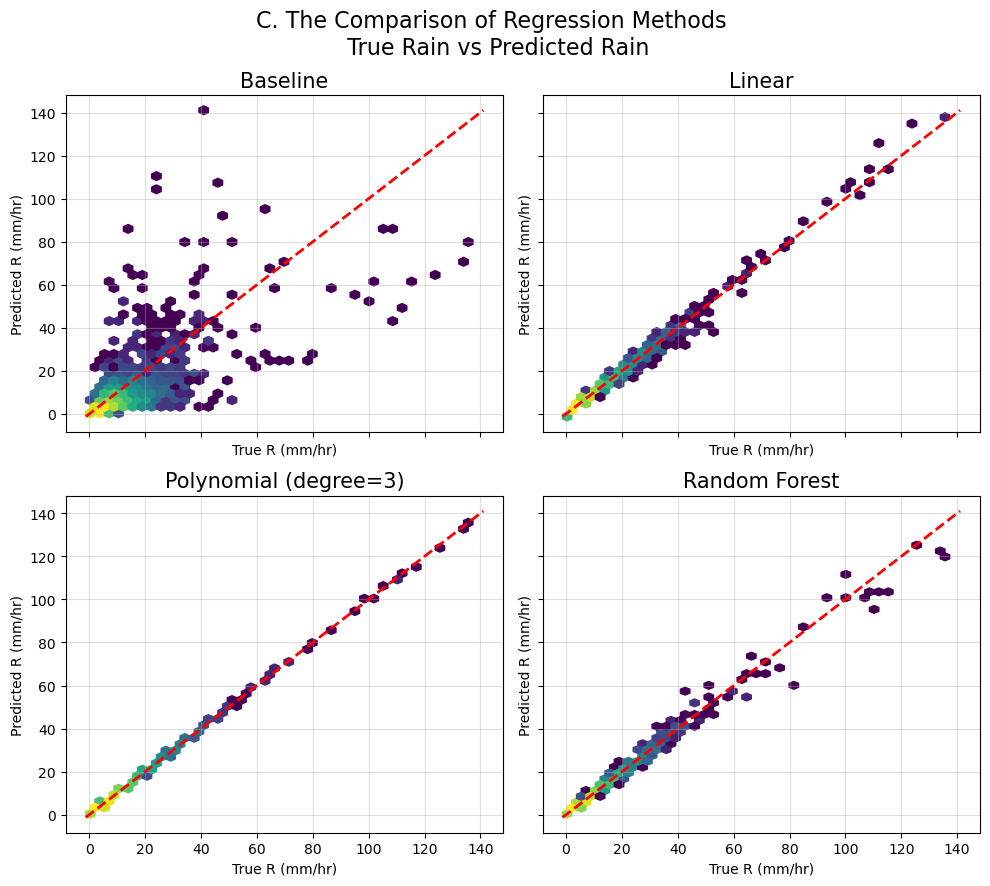

In [36]:
pred_test = [
    ("Baseline", baseline_pred_test),
    ("Linear", lin_pred_test),
    ("Polynomial (degree=3)", poly_pred_test),
    ("Random Forest", rf_pred_test),
]
#bound
all_pred = np.concatenate([p for _, p in pred_test])
vmin = float(min(y_test.min(), all_pred.min()))
vmax = float(max(y_test.max(), all_pred.max()))

fig, axes = plt.subplots(2, 2, figsize=(10,9), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (name, pred) in zip(axes, pred_test):
    hb = ax.hexbin(y_test, pred, gridsize=40, bins="log")
    ax.plot([vmin, vmax], [vmin, vmax], "r--", lw=2)
    ax.set_title(name, fontsize=15)
    ax.set_xlabel("True R (mm/hr)")
    ax.set_ylabel("Predicted R (mm/hr)")
    ax.grid(alpha=0.4)

fig.suptitle("C. The Comparison of Regression Methods \n True Rain vs Predicted Rain", y=0.98, fontsize=16)
plt.tight_layout()
plt.show()


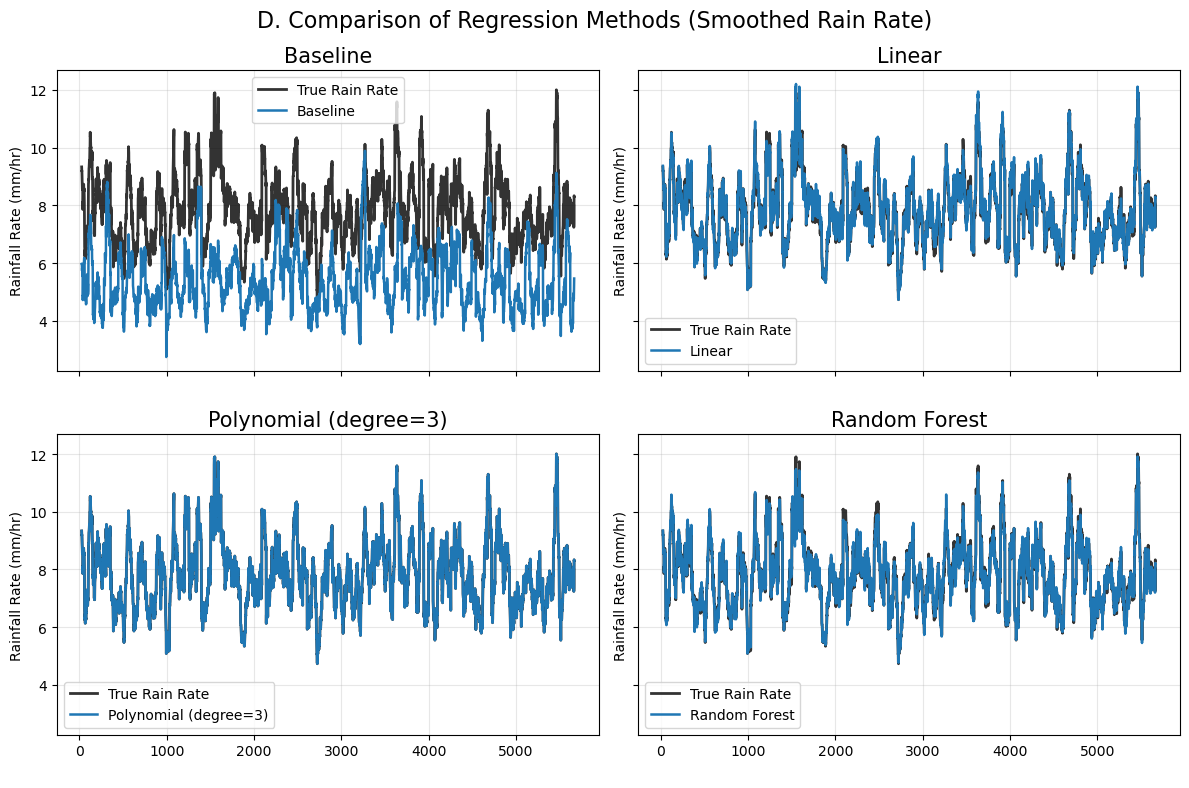

In [37]:
plot_df = pd.DataFrame({
    "True": y_test,
    "Baseline": baseline_pred_test,
    "Linear": lin_pred_test,
    "Polynomial (degree=3)": poly_pred_test,
    "Random Forest": rf_pred_test
}).reset_index(drop=True)

plot_smooth = plot_df.rolling(window=50, center=True).mean()


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

models = ["Baseline", "Linear", "Polynomial (degree=3)", "Random Forest"]

for ax, model in zip(axes, models):
    ax.plot(plot_smooth.index, plot_smooth["True"], label="True Rain Rate", color="k", alpha=0.8, lw=2)
    ax.plot(plot_smooth.index, plot_smooth[model], label=model, lw=1.8)
    
    ax.set_title(model, fontsize=15)
    ax.set_xlabel(" ")
    ax.set_ylabel("Rainfall Rate (mm/hr)")
    ax.grid(alpha=0.3)
    ax.legend()

fig.suptitle("D. Comparison of Regression Methods (Smoothed Rain Rate)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


## ANSWER FOR HW 5

#### Metrics of R2 and RMSE (Figure A and B)

* **Baseline:** weak performance and large errors.
* **Linear regression:** improve the performance better compare to baseline with a simple model and computation.
* **Polynomial (deg = 3):** almost can fit to R dataset.
* **Random forest:** Slightly better RMSE than linear.

#### Hexagon plots (Figure C)

* **Baseline:** widely scattered below the 1:1 line. This method **underestimate** the prediction of higher rain rates.
* **Linear:** closeer to the 1:1 line, with a small spread at high R and a slight tendency of **overestimation**. 
* **Polynomial (deg = 3):** almost exactly on 1:1. It has minimal bias.
* **Random forest:** closer to 1:1 but with  a slight tendency of **overestimation** at the largest R values.

#### Smoothed R time series (Figure D)

* **Baseline** can captures the timing of the true value but **underestimate the amplitude**.
* **Linear** and **random forest** can capture the timing and amplitude of the true R but at the higher R both of them lost the performance.
* **Polynomial** is **indistinguishable** from the true R and can captures the variance of amplitude.


**Summary:**
All methods outperform the **Z–R baseline** and the `polynomial regression (degree = 3)` has the best overall fit among others according to the model's evaluation on R2 and RMSE. Baseline insufficient to capture the variance since it only rely on one parameter to predict the R while other parameter don't.
Th other methods can capture the variance by involving other radar parameters to predict R. The polynomial and random forest have better performance as they can capture the nonlinearty relations. 
